In [1]:
!nvidia-smi

Thu Jan  4 00:37:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM3-32GB           On  | 00000000:34:00.0 Off |                    0 |
| N/A   31C    P0              50W / 312W |      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

In [3]:
import lightning.pytorch as pl
from lightning.pytorch import Trainer, seed_everything

import os

from pprint import pprint

import sys
sys.path.append("../src")

from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torchinfo import summary

import wandb


In [4]:
%load_ext autoreload
%autoreload 2

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["WANDB__SERVICE_WAIT"] = "300"

In [5]:
import config

from dataloader import BEDataModule

from rt1 import RTCRAM
from utils.model_utils import training_step, validation_step, run_experiment, fetch_sample_from_batch

## Build data module


In [6]:
# dm = BEDataModule()
# dm.setup()

In [7]:
# %%time
# batch = next(iter(dm.train_dataloader()))
# print(batch.keys())
# batch["in_state"].shape

In [8]:
# inp = fetch_sample_from_batch(
#     batch, 
#     batch_size=batch["in_state"].shape[0],
#     random=True
# )

## Build model


In [9]:
rt1 = RTCRAM(
    cnn_bacnbone=config.SELECTED_CNN_BACKBONE, 
    num_res_blocks=config.NUM_RES_BLOCKS,
    freeze_cnn_backbone=config.FREEZE_CNN,
    args=None
).cuda()

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b3.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnet_b3.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [10]:
# print(rt1)
summary(model=rt1)

Layer (type:depth-idx)                                            Param #
RTCRAM                                                            --
├─RTEncoder: 1-1                                                  --
│    └─TextEncoder: 2-1                                           --
│    │    └─BertModel: 3-1                                        (28,763,648)
│    │    └─Dropout: 3-2                                          --
│    └─FiLMEncoder: 2-2                                           --
│    │    └─ImageFeatureExtractor: 3-3                            10,300,456
│    │    └─ModuleList: 3-4                                       6,340,608
│    └─TokenLearnerV11: 2-3                                       --
│    │    └─Sequential: 3-5                                       134,408
├─RTDecoder: 1-2                                                  --
│    └─TransformerDecoder: 2-4                                    --
│    │    └─EmbeddingLayer: 3-6                                   52

## Training config

In [11]:
loss_fn = nn.CrossEntropyLoss(
    ignore_index=config.TGT_PAD_TOK_ID, 
    label_smoothing=config.LABEL_SMOOTHING
)
opt = getattr(torch.optim, config.OPTIMIZER)(
    params=[p for p in rt1.parameters() if p.requires_grad], 
    lr=config.LR,
    weight_decay=config.WEIGHT_DECAY
)

scheduler = getattr(lr_scheduler, config.LR_SCHEDULER["type"])(**config.LR_SCHEDULER["params"], optimizer=opt)

In [12]:
# out = validation_step(model=rt1, batch=batch, loss_fn=loss_fn)

In [13]:
# out.keys()

In [14]:
# preds= rt1.decoder.action_generator(out["logits"]).argmax(-1)
# preds

In [15]:
# rt1.decode_predictions(preds)

## Run experiment

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dric225 (jepsam-s23). Use `wandb login --relogin` to force relogin


INFO:root:Training on 3826 samples.
INFO:root:Validating on 682 samples.
INFO:root:Testing on 250 samples.


Total # examples: 4758
Loading model from checkpoint...
Loading model from checkpoint...Complete!


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

KeyboardInterrupt: 

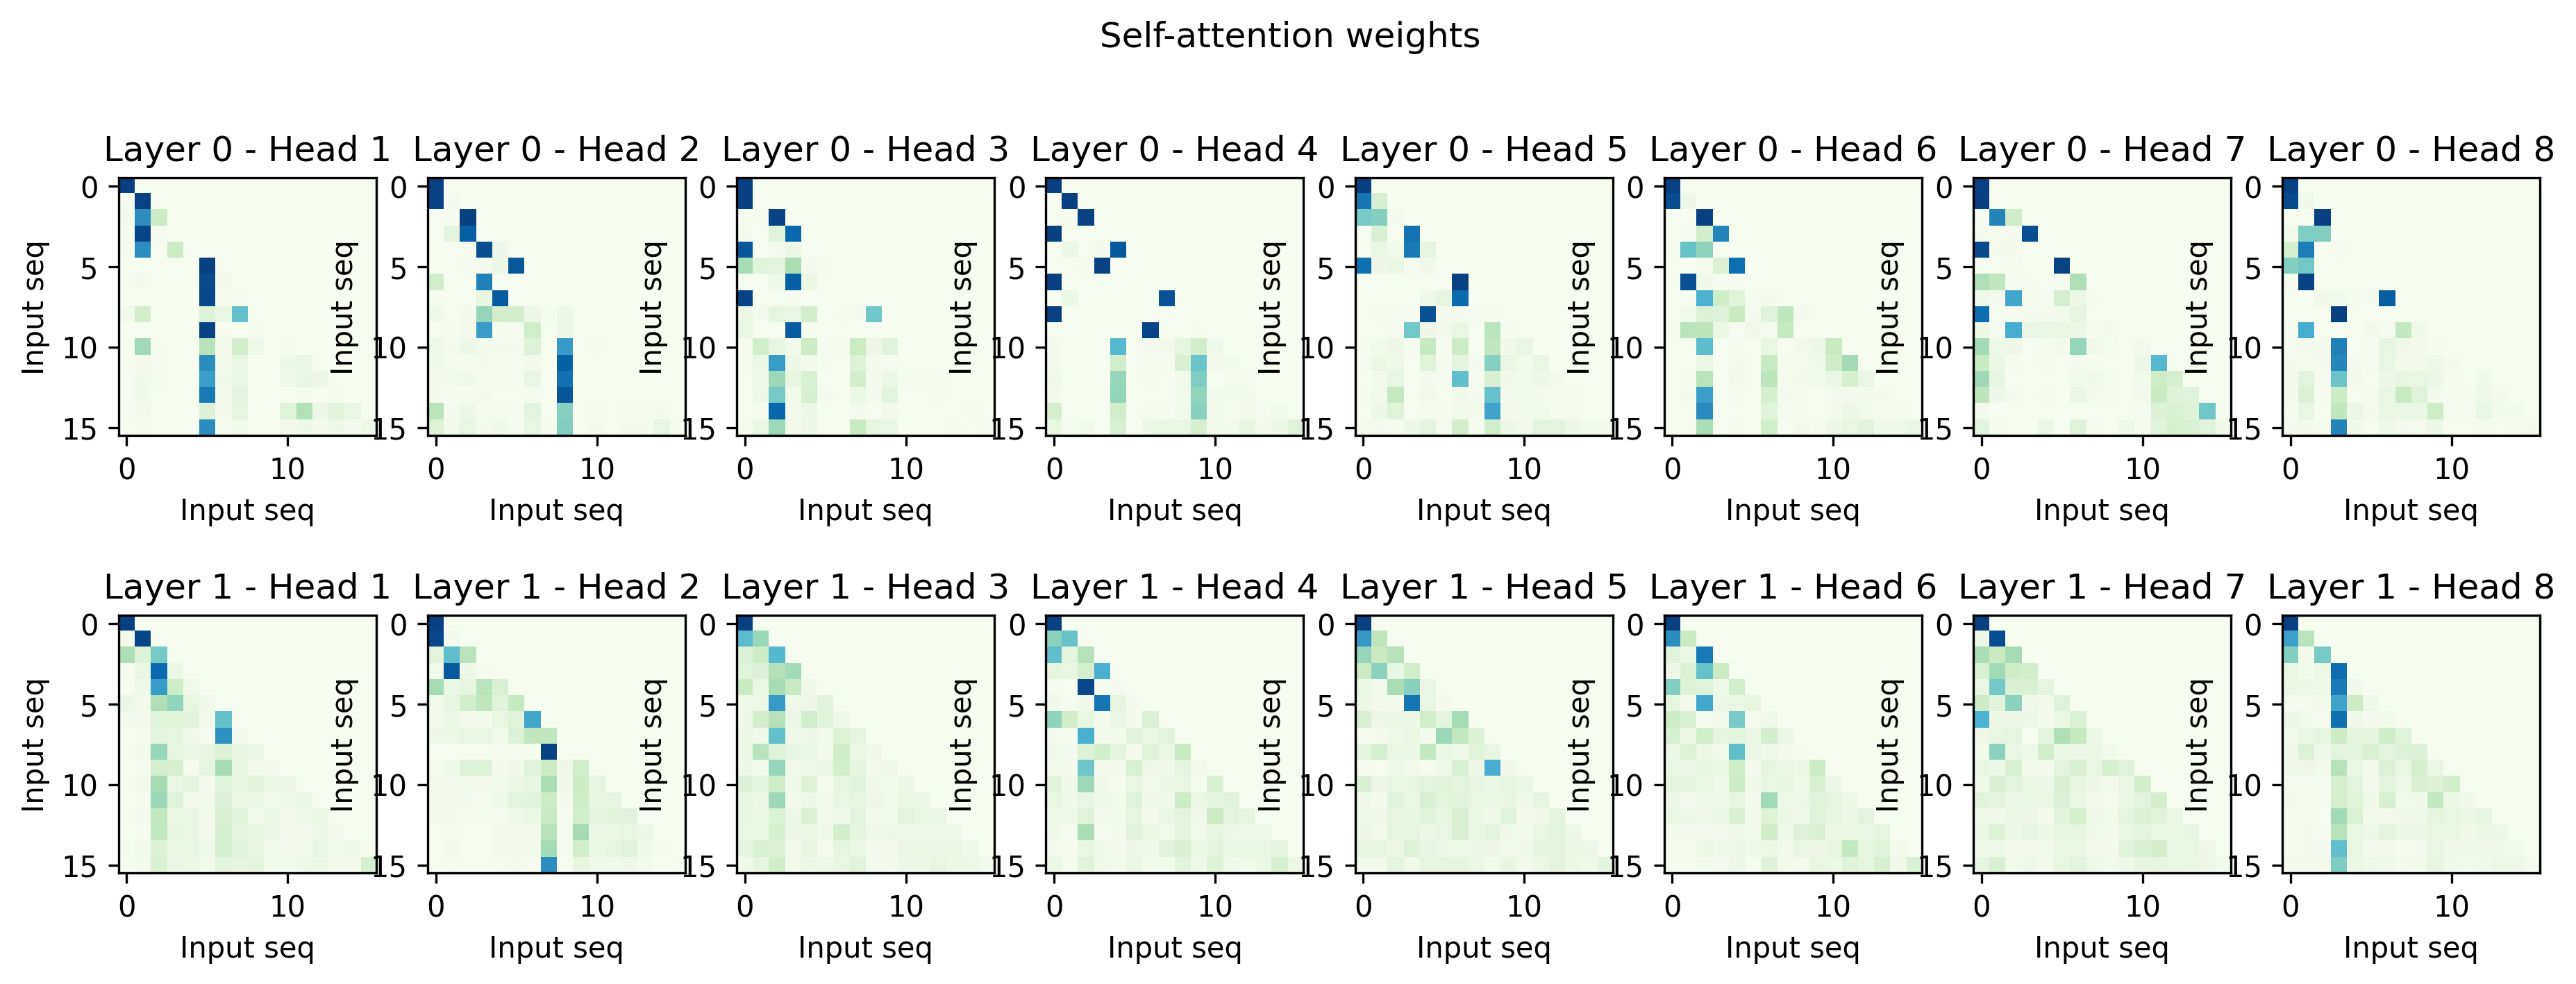

In [16]:
dm = BEDataModule()

run = wandb.init(
    dir='../',
    project='SMF-Be', 
    group="RT1-CRAM", 
    name="be_model", 
    reinit=True
)

trained_model = run_experiment(
    model=rt1, 
    dm=dm, 
    opt=opt, 
    loss_fn=loss_fn,
    scheduler=scheduler,
    resume_training=True,
    epoch_resume=56
)

In [ ]:
!nvidia-smi